In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from quant_free.dataset.us_equity_load import *
from quant_free.utils.us_equity_utils import *
from quant_free.factor.price import *


from quant_free.finml.utils.multiprocess import mp_pandas_obj

symbol = 'TSM'
symbol = 'AAPL'
symbol = 'INTC'

factor_name = 'Trend.csv'
like1 = 'trend'
like2 = 'ret_forward_'

# factor_name = 'Alpha101.csv'
# like1 = 'alpha'
# like2 = 'ret_forward_'

thr = 0.00
forward_period = 10
start_date = get_json_config_value("start_date")
end_date = get_json_config_value("end_date")

factor = us_equity_data_load_within_range(symbols = [symbol], start_date = start_date,
                                end_date = end_date, column_option = "all", file_name = factor_name)[symbol]
factor = factor.replace({True: 1, False: 0})
factor = factor.loc[:, (factor != 0).any(axis=0)]

filtered_1 = factor.filter(like=like1)

filtered_2 = factor.filter(like=like2)
cols_to_keep = [col for col in filtered_2.columns if not any(int(s) >= forward_period for s in col.split('_') if s.isdigit())]
filtered_2 = filtered_2[cols_to_keep]

factor_filter = pd.concat([filtered_1, filtered_2], axis=1)


trnsX = factor_filter.astype(np.float64)

# price_ratio = PriceRatio(start_date, end_date, symbol = symbol, column_option = 'close', dir_option = 'xq')
# y_data = price_ratio.price_ratio(periods = periods)
y_data = factor.loc[:, f'ret_forward_{forward_period}']
cont = pd.DataFrame(y_data.map(lambda x: 1 if x > thr else 0 if x < -thr else 0))
cont = pd.concat([cont, y_data], axis = 1)
cont.columns = ['bin', f'price_ratio_{forward_period}']
cont['t1'] = cont.index

print(cont.tail(10))


            bin  price_ratio_10         t1
2024-09-23    1        0.033764 2024-09-23
2024-09-24    1        0.033764 2024-09-24
2024-09-25    1        0.033764 2024-09-25
2024-09-26    1        0.033764 2024-09-26
2024-09-27    1        0.033764 2024-09-27
2024-09-30    1        0.033764 2024-09-30
2024-10-01    1        0.033764 2024-10-01
2024-10-02    1        0.033764 2024-10-02
2024-10-03    1        0.033764 2024-10-03
2024-10-04    1        0.033764 2024-10-04


In [2]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

ols = sm.Logit(cont['bin'], trnsX).fit()

Optimization terminated successfully.
         Current function value: 0.419589
         Iterations 34


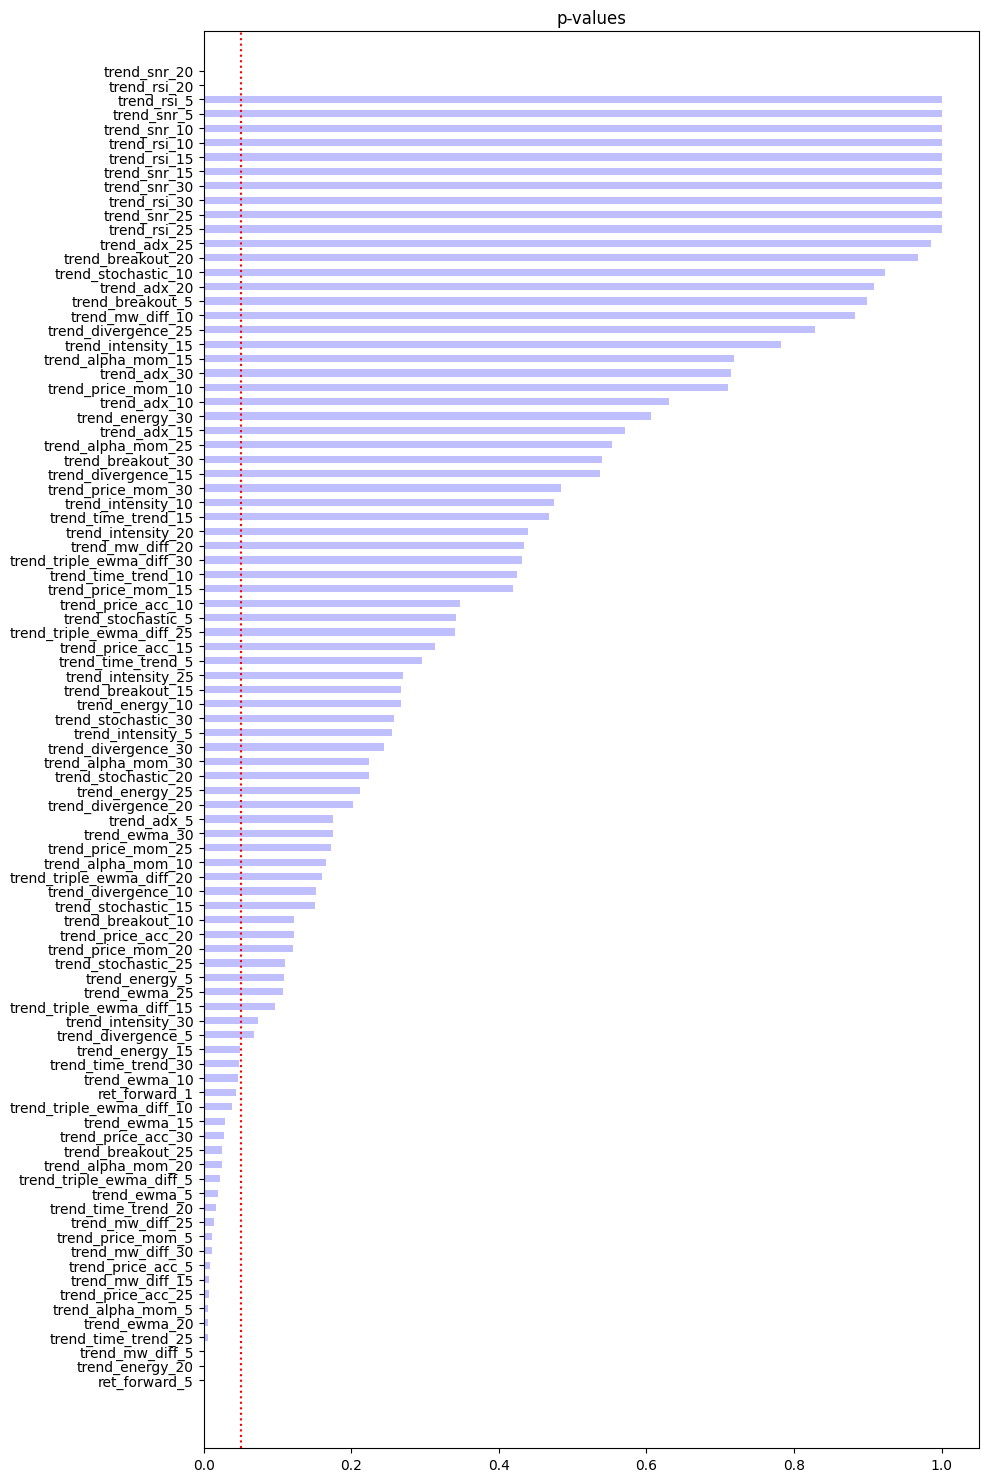

In [3]:
plt.figure(figsize=(10, len(ols.pvalues) * 0.20))
plt.barh(
    ols.pvalues.sort_values(ascending = True).index, 
    ols.pvalues.sort_values(ascending = True), 
    color = 'b', alpha = 0.25, height = 0.5
)

plt.axvline(0.05, ls = ':', color = 'r')
plt.grid(False)
plt.title('p-values')
plt.show()

In [4]:
from sklearn.ensemble import RandomForestClassifier
from quant_free.finml.feature_importance import *

forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 100,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

# fit = forest.fit(X = trnsX, y = cont['bin'])
# oob_score = fit.oob_score_
# print(f"oob_score {oob_score}")

from quant_free.finml.cross_validation.cross_validation import PurgedKFold, cross_val_score
from quant_free.finml.feature_importance.importance import *
cv_gen = PurgedKFold(
    n_splits = 20, 
    samples_info_sets = cont['t1']
)

def compute_feature_importance(clf, X, y, cv_gen, molecule):
    scoring = log_loss
    sample_weight = None
    
    factor_ = X.loc[:, molecule]
    sfi = single_feature_importance(
        clf, # base classification model
        factor_, # train features
        cont['bin'], # train labels
        cv_gen, # purged k fold cross validation class
        scoring = accuracy_score
    )
    
    return sfi

In [5]:
def single_feature_importance_parallel(clf, X, y, cv_gen, scoring = log_loss, sample_weight = None):
    feature_names = X.columns
    if sample_weight is None:
        sample_weight = np.ones((X.shape[0],))

    num_threads=8
    imp = mp_pandas_obj(
                        func = compute_feature_importance,
                        pd_obj = ('molecule', feature_names),
                        num_threads =num_threads,
                        clf = clf,
                        X = X,
                        y = y,
                        cv_gen = cv_gen
                        )
    # imp = imp.set_index('index')
    return imp

sfi = single_feature_importance_parallel(
    forest, # base classification model
    factor_filter, # train features
    cont, # train labels
    cv_gen, # purged k fold cross validation class
    scoring = accuracy_score
)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [03:04<00:00, 15.39s/it]e_importance done after 3.06 minutes. Remaining 0.44 minutes.
2025-02-16 12:40:17.390940 100.0% compute_feature_importance done after 3.08 minutes. Remaining 0.0 minutes.


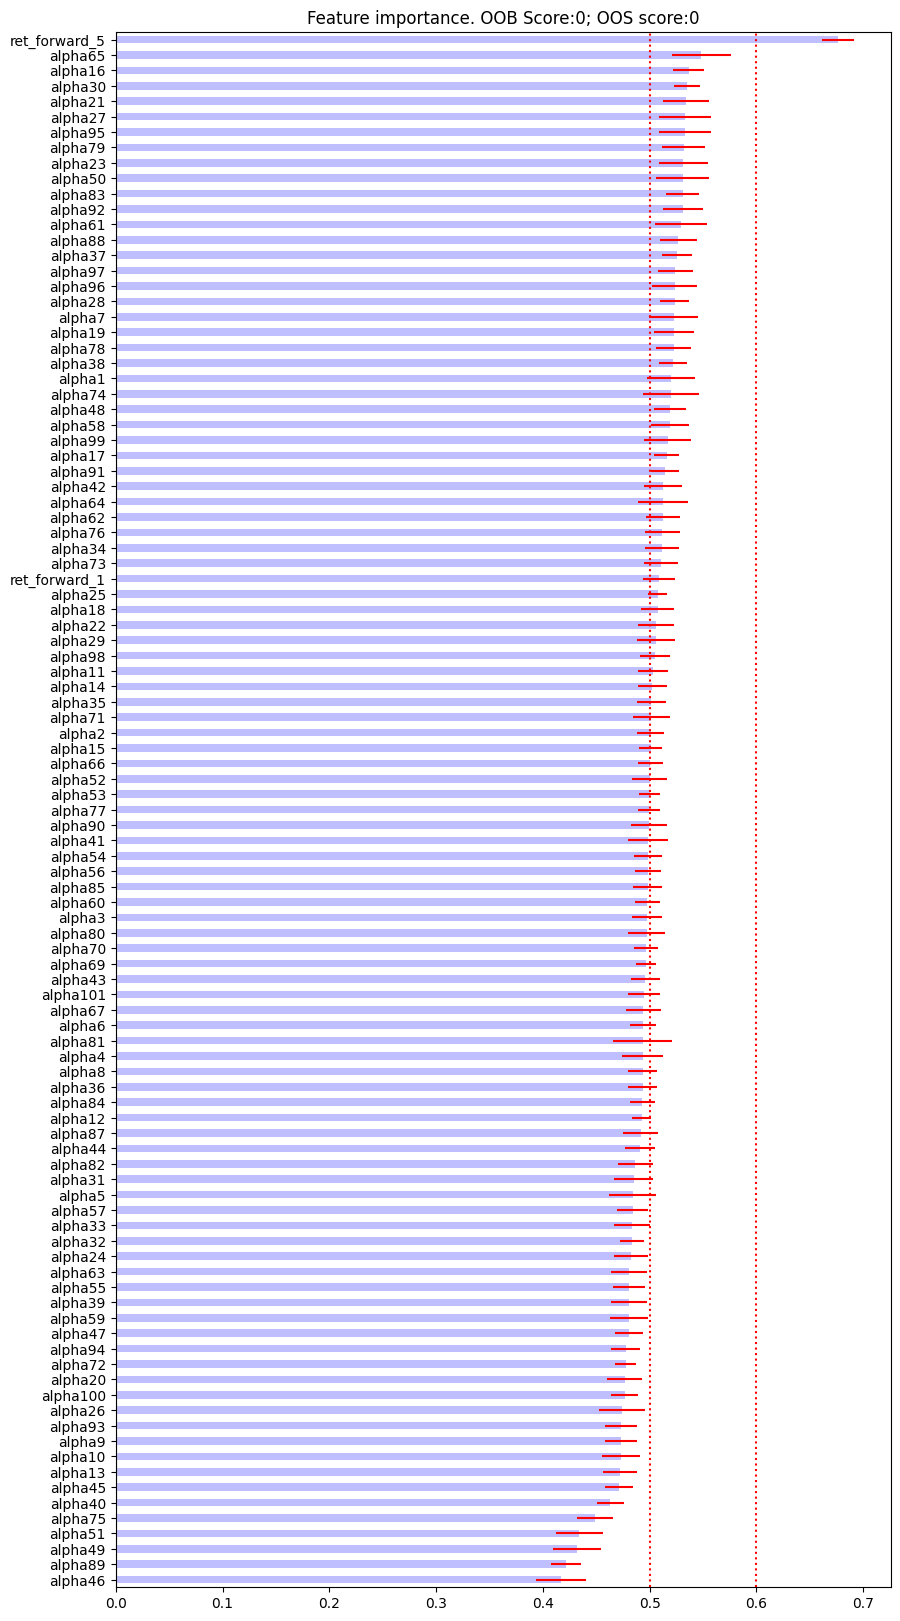

In [9]:
plot_feature_importance(
    sfi,
    oob_score = 0,
    oos_score = 0,
    save_fig = True,
    output_path = f'./research/finML/factor_analysis/images/{symbol}_{like1}_SFI_feature_importance.png'
)
plt.axvline(0.5, ls = ':', color = 'r')
plt.axvline(0.6, ls = ':', color = 'r')
plt.grid(False)
plt.show()

In [10]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from quant_free.finml.feature_importance import *

forest = RandomForestClassifier(
    # criterion = 'entropy',
    criterion = 'gini',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 100,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

from quant_free.finml.cross_validation.cross_validation import PurgedKFold, cross_val_score
from quant_free.finml.feature_importance.importance import *
cv_gen = PurgedKFold(
    n_splits = 20, 
    samples_info_sets = cont['t1']
)

oos_score = cross_val_score(
    forest, # base classifier
    trnsX, # train features
    cont['bin'], # train labels
    cv_gen = cv_gen, # purged k fold cross validation class
    scoring = accuracy_score # optimizing to accuracy score
).mean()

mdi = mean_decrease_impurity(fit, trnsX.columns)

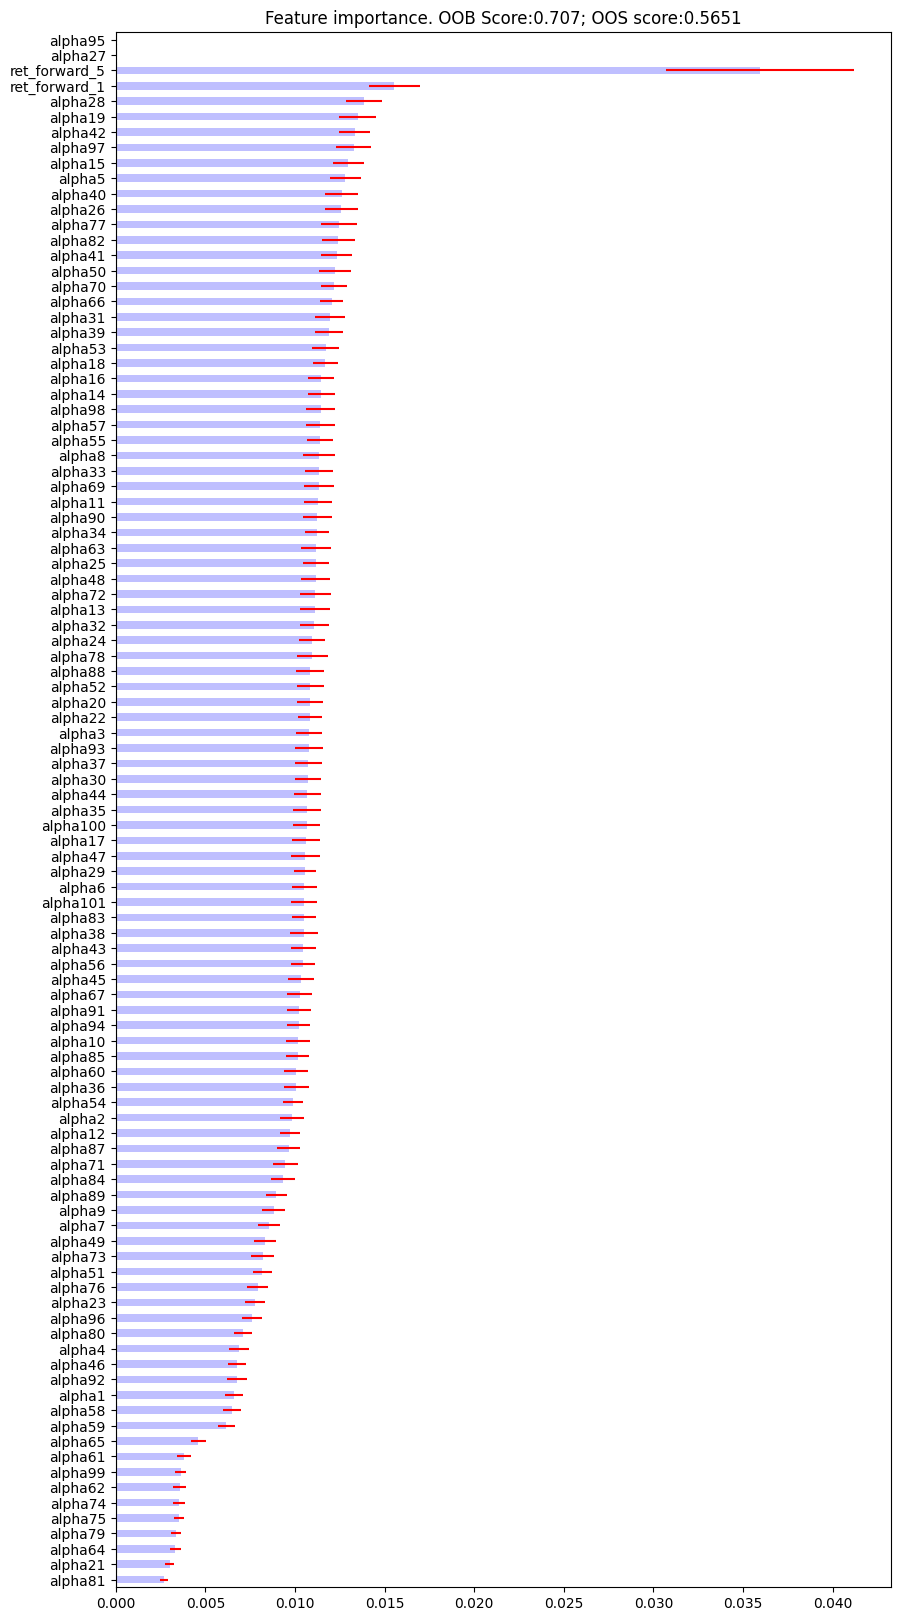

In [11]:
plot_feature_importance(
    mdi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = f'./research/finML/factor_analysis/images/{symbol}_{like1}_MDI_feature_importance.png'
)
plt.grid(False)
plt.show()

In [12]:
forest = RandomForestClassifier(
    # criterion = 'gini',
    # criterion = 'entropy',
    criterion = 'log_loss',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 100,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

oos_score = cross_val_score(
    forest, # base classifier
    trnsX, # train features
    cont['bin'], # train labels
    cv_gen = cv_gen, # purged k fold cross validation class
    scoring = accuracy_score # optimizing to accuracy score
).mean()

In [15]:
mda = mean_decrease_accuracy(
    fit, # base classification model
    trnsX, # train features
    cont['bin'], # train labels
    cv_gen, # purged k fold cross validation class
    scoring = accuracy_score
)

mda.sort_values('mean', ascending=False).head()

20it [00:12,  1.63it/s]


,mean,std
ret_forward_5,0.126664,0.020029
ret_forward_1,0.045813,0.016275
alpha75,0.02907,0.010523
alpha92,0.024367,0.010894
alpha5,0.019549,0.008416


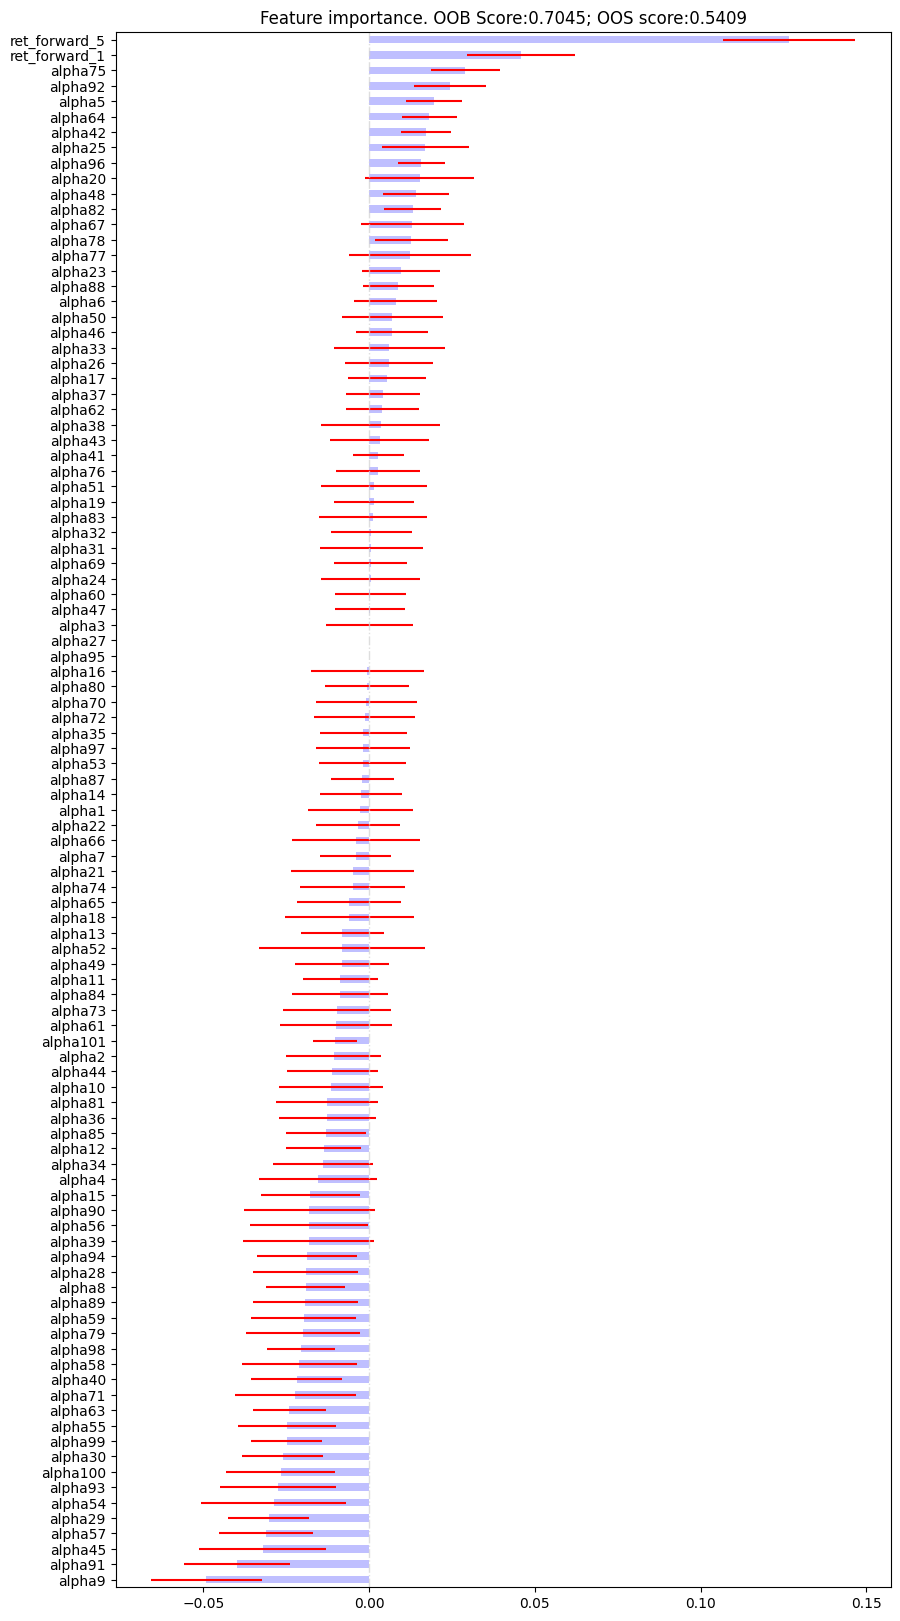

In [16]:
plot_feature_importance(
    mda,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = f'./research/finML/factor_analysis/images/{symbol}_{like1}_MDA_feature_importance.png'
)
plt.grid(False)
plt.show()

In [17]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

In [30]:
import shap

forest_explain = shap.TreeExplainer(fit)
shap_values_train = forest_explain(trnsX)

In [1]:
# import matplotlib.pyplot as plt
# plt.grid(False)
# plt.title('SHAP Value')
# shap.plots.beeswarm(
#     shap_values_train[:,:,1], 
#     max_display = len(shap_values_train.feature_names),
#     plot_size = (8, shap_values_train.shape[1] * 0.5)
# )

# plt.show()

shap.summary_plot(shap_values_train, trnsX, show=False)

NameError: name 'shap' is not defined